### Actor-Critic for MountainCar-v0

In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from IPython.display import clear_output

In [2]:
env = gym.make("MountainCar-v0").env
s = env.reset()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

In [3]:
env.observation_space.low

array([-1.2 , -0.07], dtype=float32)

In [4]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.dense1 = nn.Linear(obs_shape[0], 400)
        self.dense2 = nn.Linear(400, n_actions)
        self.dense3 = nn.Linear(400, 1)

    def forward(self, x):
        x = torch.FloatTensor(x)
        x = self.dense1(x)
        x = F.relu(x)
        logits = self.dense2(x)
        values = self.dense3(x)

        return logits, values

In [5]:
agent = Network()

In [6]:
def where(cond, x1, x2):
    return (1 - cond)*x1 + cond*x2

[0.33448875 0.37953526 0.28597602]
episode: 499001, env_reward: -1.0, reward: -1.1624258756637573
Critic loss: 0.008337259 Actor loss: -1.3973007


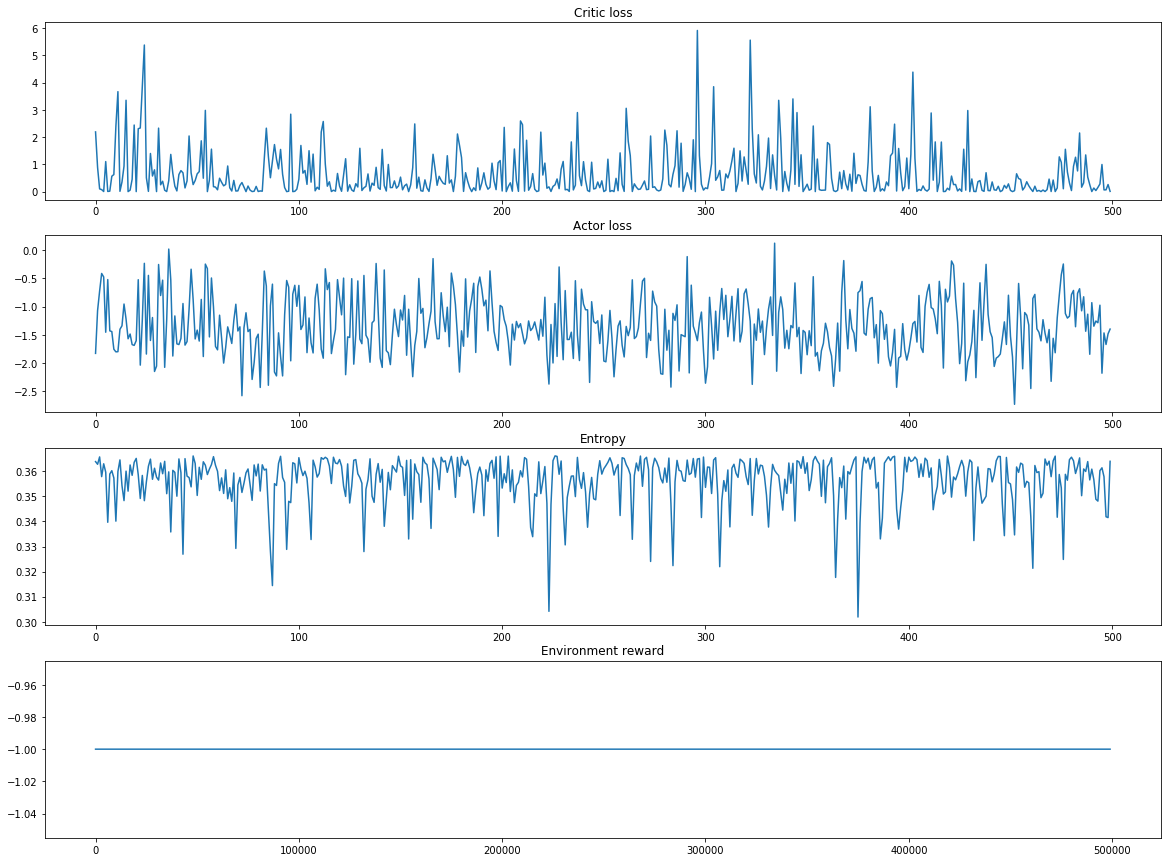

CPU times: user 1h 8min 37s, sys: 4min 21s, total: 1h 12min 58s
Wall time: 29min 1s


In [7]:
%%time
gamma = 0.99
opt = torch.optim.Adam(agent.parameters(), lr=5e-5)
rewards = []
env_rewards = []
actorLoss = []
criticLoss = []
Entropy = []
state = env.reset()
for i_episode in range(500000):
    logits, values = agent(state)
    policy = F.softmax(logits)
    log_policy = F.log_softmax(logits)
    action = np.random.choice(n_actions, p=policy.data.numpy())
    next_state, env_reward, done, _ = env.step(action)
    reward = torch.FloatTensor([env_reward + np.sin(3*state[0])]) # np.abs(state[0] + 0.5)
    next_logits, next_values = agent(next_state)
    # actor
    entropy = -torch.mean(policy * log_policy)
    advantage = reward + gamma * next_values - torch.squeeze(values)
    advantage = reward if not done else reward + gamma * next_values - torch.squeeze(values)
    actor_loss = -0.5*entropy - torch.mean(advantage.detach() * log_policy[action])
    # critic
    td_target = reward + gamma * next_values if not done else reward
    critic_loss = torch.mean((td_target.detach() - values) ** 2)

    rewards.append(reward)
    state = next_state
    env_rewards.append(env_reward)
    loss = actor_loss + critic_loss
    loss.backward()
    opt.step()
    opt.zero_grad()

    if done:
        state = env.reset()
        continue
    if i_episode % 1000 == 0:
        clear_output(True)
        actorLoss.append(actor_loss.data.numpy())
        criticLoss.append(critic_loss.data.numpy())
        Entropy.append(entropy.data.numpy())
        print(policy.data.numpy())
        print("episode: {}, env_reward: {}, reward: {}".format(i_episode + 1, 
                                                               np.mean(env_rewards[-10:]),
                                                               np.mean(rewards[-10:])
                                                              ))
        print("Critic loss:", criticLoss[-1], "Actor loss:", actorLoss[-1])
        plt.figure(figsize=(20, 15))
        plt.subplot(411)
        plt.plot(criticLoss)
        plt.title("Critic loss")
        plt.subplot(412)
        plt.plot(actorLoss)
        plt.title("Actor loss")
        plt.subplot(413)
        plt.plot(Entropy)
        plt.title("Entropy")
        plt.subplot(414)
        plt.plot(env_rewards)
        plt.title("Environment reward")
        plt.show()

In [8]:
from collections import Counter
print(Counter(env_rewards))

Counter({-1.0: 38449})


In [9]:
state = env.reset()
for t in range(1000):
    logits, values = agent(state)
    action = np.random.choice(n_actions, p=F.softmax(logits).data.numpy())
    next_state, reward, done, _ = env.step(action)
    
    state = next_state
    env.render()
    if done:
        state = env.reset()
        continue
        
env.close()

/home/nik-96/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


### Actor-critic for MountainCarContinuous-v0

### link on tensorflow implementation of A2C for MountainCarContinuous-v0
https://github.com/dennybritz/reinforcement-learning/blob/master/PolicyGradient/Continuous%20MountainCar%20Actor%20Critic%20Solution.ipynb

In [2]:
env = gym.make("MountainCarContinuous-v0")
s = env.reset()

In [3]:
obs_shape = env.observation_space.shape
action_shape = env.action_space.shape

In [5]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.dense1 = nn.Linear(obs_shape[0], 200) 
        self.dense2 = nn.Linear(200, 1)
        self.dense3 = nn.Linear(200, 1)
        
        
    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32).to(device)
        x = F.tanh(self.dense1(x))
        self.mu = self.dense2(x)
        self.sigma = self.dense3(x)
        
        self.mu = torch.squeeze(self.mu)
        self.sigma = F.softplus(torch.squeeze(self.sigma)) + 1e-5
        self.normal = torch.distributions.normal.Normal(self.mu, self.sigma)
        actions = self.normal.sample(sample_shape=torch.Size(action_shape))
        actions = torch.clamp(actions, env.action_space.low[0], env.action_space.high[0])
        return actions
    
    def get_entropy(self):
        return self.normal.entropy()
    
    def get_log_prob(self, action):
        return self.normal.log_prob(action)

In [6]:
class ValueNetwork(nn.Module):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        self.dense1 = nn.Linear(obs_shape[0], 200)
        self.dense2 = nn.Linear(200, 1)
        
    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32).to(device)
        x = F.tanh(self.dense1(x))
        v_s = self.dense2(x)
        
        return v_s

In [7]:
policy_estimator = PolicyNetwork().to(device)
policy_estimator([s]).shape

torch.Size([1])

In [8]:
env.action_space.sample().shape

(1,)

In [9]:
value_estimator = ValueNetwork().to(device)

In [10]:
def generate_session(tmax=1000):
    states, actions, rewards, dones, next_states = [], [], [], [], []
    s = env.reset()
    for i in range(tmax):
        action = policy_estimator([s])
        new_s, reward, done, info = env.step(action.cpu().data.numpy())
        
        if done:
            break
        
        states.append(s)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        next_states.append(new_s)
        s = new_s
        
    return states, actions, rewards, dones, next_states

In [11]:
states, actions, rewards, dones, next_states = generate_session()

In [12]:
def compute_critic_loss(optimizer, states, rewards, next_states, gamma):
    states = torch.tensor(states, dtype=torch.float32).to(device)
    next_states = torch.tensor(next_states.astype('float'), dtype=torch.float32).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_v_s = value_estimator(next_states).detach()
    td_target = rewards + gamma*next_v_s
    td_error = (td_target - value_estimator(states))**2
    loss = torch.mean(td_error)
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()
    
    return loss.cpu().data.numpy()

In [13]:
def compute_actor_loss(optimizer, states, actions, rewards, next_states, gamma):
    H = policy_estimator.get_entropy()
    states = torch.tensor(states, dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.float32).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.tensor(next_states.astype('float'), dtype=torch.float32)
    td_target = rewards + gamma*value_estimator(next_states)
    td_error = td_target - value_estimator(states)
    loss = -0.1*H - policy_estimator.get_log_prob(actions)*td_error.detach()
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return loss.cpu().data.numpy()

In [14]:
def train(gamma=0.99, episodes=10, tmax=1000):
    opt = torch.optim.Adam(list(policy_estimator.parameters()) + list(value_estimator.parameters()), lr=1e-3)
    rewards = []
    loss_values_L = []
    loss_values_J = []
    for i_episode in range(episodes):
        state = env.reset()
        episode_rewards = []
        
        for t in range(tmax):
            
            action = policy_estimator(state)
            next_state, reward, done, _ = env.step(action)
            
            episode_rewards.append(reward)
            
            Ltd = compute_critic_loss(opt, state, reward, next_state, gamma)
            
            J = compute_actor_loss(opt, state, action, reward, next_state, gamma)
            if t % 500 == 0:
                loss_values_J.append(J)
                loss_values_L.append(Ltd)
            
            state = next_state
            if done:
                break
        
        rewards.append(np.mean(np.array(episode_rewards)))
        clear_output(True)
        print("episode: {}, reward: {}".format(i_episode + 1, np.mean(np.array(episode_rewards))))
        print(loss_values_J[-1])
        plt.subplot(121)
        plt.plot(loss_values_L)
        plt.title("Ltd loss")
        plt.subplot(122)
        plt.plot(loss_values_J)
        plt.title("J_hat loss")
        plt.show()
        
    return np.array(rewards)

In [19]:
normal = torch.distributions.normal.Normal(0, 1)

In [20]:
normal.entropy()

tensor(1.4189)

episode: 10, reward: -0.0004209252504765729
[-0.46652836]


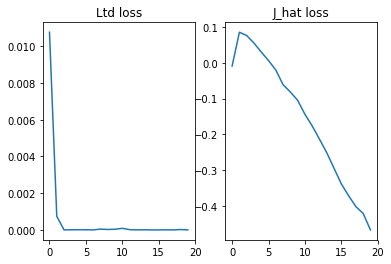

array([-3.51630868e-02, -1.68083060e-02, -7.01596445e-03, -2.37690489e-03,
       -6.90292012e-04, -3.27295153e-04, -8.47560537e-05, -3.29564471e-04,
       -2.02674452e-04, -4.20925250e-04])

In [15]:
train()

In [17]:
state = env.reset()
for t in range(1000):
    action = policy_estimator(state).to('cpu')
    next_state, reward, done, _ = env.step(action)
    
    state = next_state
    env.render()
    if done:
        break
        
env.close()